# SPDE simulation on sphere

In [1]:
import numpy as np           
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import IPython
import scipy as sc
import gstlearn as gl
import gstlearn.plot as gp
from numpy import pi, cos, sin
import scipy as sc
from scipy.sparse.linalg import spsolve

## Parametrization

In [2]:
R = 1. #Sphere radius

gl.variety_define(1,R)

ratioRange = 0.1  #Scale parameter (proportion of the radius)
param = 2 # parameter of the Matérn
sill = 2. # sill 


## Meshing

In [3]:
mesh = gl.MeshSpherical()
err = mesh.reset(None,None,triswitch = "-r5",verbose=False)

In [4]:
model = gl.Model.createFromParam(type=gl.ECov.BESSEL_K,range = R * ratioRange,
                                   sill = sill,
                                   param=param,
                                   flagRange= False)
model


Model characteristics
Space dimension              = 2
Number of variable(s)        = 1
Number of basic structure(s) = 1
Number of drift function(s)  = 0
Number of drift equation(s)  = 0

Covariance Part
---------------
K-Bessel (Third Parameter = 2)
- Sill         =      2.000
- Range        =      0.490
- Theo. Range  =      0.100
Total Sill     =      2.000

## Shift Operator and Precision matrix

In [5]:
S=gl.ShiftOpCs(mesh,model)
Q = gl.PrecisionOpCs(S,model.getCova(0),gl.EPowerPT.MINUSHALF)

## Simulation 

In [6]:
whitenoise = gl.ut_vector_simulate_gaussian(mesh.getNApices())
result = gl.VectorDouble(mesh.getNApices())
Q.eval(whitenoise,result)

## Display the realization
 

In [7]:
X = mesh.getCoordinates(0)
Y = mesh.getCoordinates(1)

coords = np.array(gl.util_convert_longlat(X,Y,dilate=0.99))

meshes = np.array(mesh.getMeshes()).reshape([mesh.getNMeshes(),3])-1

cscale = [[0.0, '#313695'],
 [0.07692307692307693, '#3a67af'],
 [0.15384615384615385, '#5994c5'],
 [0.23076923076923078, '#84bbd8'],
 [0.3076923076923077, '#afdbea'],
 [0.38461538461538464, '#d8eff5'],
 [0.46153846153846156, '#d6ffe1'],
 [0.5384615384615384, '#fef4ac'],
 [0.6153846153846154, '#fed987'],
 [0.6923076923076923, '#fdb264'],
 [0.7692307692307693, '#f78249'],
 [0.8461538461538461, '#e75435'],
 [0.9230769230769231, '#cc2727'],
 [1.0, '#a50026']]


fig = go.Figure(data=[
    go.Mesh3d(
        x=coords[0,:],
        y=coords[1,:],
        z=coords[2,:],
        colorbar_title='z',
        colorscale=cscale,
        # Intensity of each vertex, which will be interpolated and color-coded
        intensity=np.array(result),
        # i, j and k give the vertices of triangles
        # here we represent the 4 triangles of the tetrahedron surface
        i=meshes[:,0],
        j=meshes[:,1],
        k=meshes[:,2],
        name='y',
        showscale=True
    )
])

fig.show()

## Compute variance (of discretized solution)

We use the fact that $\Sigma = Q^{-1}$ and solve $Qx = e_1$. 
The resulting **x[0]** is the variance of the discretized model for the first point of the meshing.

In [8]:

Qt = gl.csToTriplet(Q.getQ())
Qmat=sc.sparse.csc_matrix((np.array(Qt.values), (np.array(Qt.rows), np.array(Qt.cols))),
                          shape=(Qt.nrows,Qt.ncols))

spsolve(Qmat,np.eye(Qmat.shape[0],1))[0]


2.042343316989841

## Compute Variogram of the realization

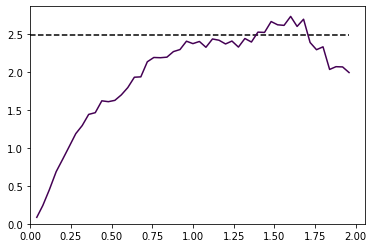

In [9]:
npas = 50 # number of discretization points
dpas = 0.04 # lag with respect to the unit sphere (it will be multiplied
# by R in the creation of the VarioParam.

nsample = 4000
#sub-sampling to reduce computational burden

ind = np.random.choice(mesh.getNApices(),size=nsample,replace=False)

#Creation of the db

dbdat = gl.Db.create()
dbdat["x"] = np.array(X)[ind]
dbdat["y"] = np.array(Y)[ind]
dbdat["z"] = np.array(result)[ind]
dbdat.setLocators(["x","y"],gl.ELoc.X)
dbdat.setLocators(["z"],gl.ELoc.Z)

#Variogram 

vp = gl.VarioParam.createOmniDirection(npas=npas,dpas=dpas * R)
vario = gl.Vario.create(vp,dbdat)
vario.compute(gl.ECalcVario.VARIOGRAM)

ax=gp.plot(vario)

## Theoretical covariance function

This function compute the covariance function on the sphere for a given array **h** and a spectrum $f$.

The covariance between two points with great-circle distance $\alpha$  on the unit sphere is given by
$$C(\alpha) = \sum_{i=0}^n f(i) P_i(\cos \alpha)$$

where the $P_i$'s  are the Legendre polynomials computed with the following reccurence formula

$$P_0(x) = 1.$$

$$P_1(x) = x$$

$$P_{n+1}(x)=\frac{(2n+1)xP_n(x) - n P_{n-1}(x)}{n+1}$$

The sum is truncated at **N**. Assuming that **h[0] = 0**, the result is divided by **C(0)** if **normalize = True**.

In [11]:
model.getCova(0).getCova().evalCovOnSphere(0)

AttributeError: 'ACovFunc' object has no attribute 'evalCovOnSphere'

In [ ]:
def computeCov(h,f, N = 100 , normalize = True):
    s = 0.
    u0 = np.ones_like(h)
    u1 = h.copy()
    for i in range(1,N):
        u2 = 1/(i+1) * ((2*i+1) * h * u1 - i * u0)
        s += f(i-1) * u0
        u0 = u1
        u1 = u2
    if normalize:
        s/=s[0]
    return s


The following class provides the spectrum of the Matern covariance function on the sphere.

In [ ]:

class Matern :
    def __init__(self,cova):
        self.kappa2 = 1./cova.getScales()[0]**2
        self.alpha = cova.getParam()+1
    def eval(self,n) :
        return (2.*n+1)/(self.kappa2 + n * (n+1))**self.alpha



## Evaluation 

In [ ]:
ndisc = 100 # number of discretization steps for the covariance 
npoly = 50 # size of the decomposition
matern = Matern(model.getCova(0))

hnorm = np.linspace(0,npas * dpas,ndisc)
hval = R * hnorm
CosH = np.cos(hnorm)
res = computeCov(CosH,matern.eval,npoly)

ax=gp.vario(vario,end_plot=False)
ax = plt.plot(hval,sill - sill * res)